In [ ]:
import requests
import json

states_url='https://liveresultsapi.civichive.org/api/v1/states' #url to the hidden APi
states_raw=requests.get(states_url).text #get response as text
states_data=json.loads(states_raw) #convert to json
states_slug=[i['slug'] for i in states_data['data']] #get the slug name for each state(to access each states data)
states_name=[i['name'] for i in states_data['data']] #get the name for each state

nation_df=[]#create a list to save each states data


#this loop goes over each state and retrieve the election data for the presidential election
for state, slug in zip(states_name,states_slug):
    result_url=f'https://liveresultsapi.civichive.org/api/v1/election/{slug}/2023/data'
    result_raw=requests.get(result_url).text
    result_data=json.loads(result_raw)
    party_votes={d['abbr']:d['vote'] for d in result_data['data']['presidential']['parties']}
    reg_voters=result_data['data']['presidential']['registeredVote']
    total_votes=result_data['data']['presidential']['totalVote']
    state_df = pd.DataFrame([[state]+list(party_votes.values())+[total_votes]+ [reg_voters]], columns=['State']+list(party_votes.keys())+['Total Votes','Registered Voters'])
    nation_df.append(state_df)
    
    
final=pd.concat(nation_df) #concatenate all state dataframe into one
final=final.reset_index().drop('index', axis=1)#reset the index
final.to_csv('election data.csv', index=False)#save it

In [107]:
import pandas as pd
df=pd.read_csv('election data.csv')
major_parties = ['LP', 'APC', 'NNPP', 'PDP']
other_parties = [col for col in df.columns if col not in major_parties and col not in ['State', 'Total Votes', 'Registered Voters']]
df['Others'] = df[other_parties].sum(axis=1)
df.drop(columns=other_parties, inplace=True)
df['Voters Turnout(%)'] = df['Total Votes']*100/df['Registered Voters']
df['Winner'] = df[['LP', 'NNPP', 'PDP', 'APC']].idxmax(axis=1)
df['Winner'] = df['Winner'].map({'LP': 'LP', 'NNPP': 'NNPP', 'PDP': 'PDP', 'APC': 'APC'})


In [108]:
zone={
    'north_central':['Benue','Kogi','Kwara','Nasarawa','Niger','Plateau','Federal Capital Territory'],
    'north_east': ['Adamawa','Bauchi','Borno','Gombe','Taraba','Yobe'],
    'north_west': ['Jigawa','Kaduna','Kano','Katsina','Kebbi','Sokoto','Zamfara'],
    'south_east': ['Abia','Anambra','Ebonyi','Enugu','Imo'],
    'south_south':['Akwa Ibom','Bayelsa','Cross River','Delta','Edo','Rivers'],
    'south_west':['Ekiti','Lagos','Ogun','Ondo','Osun','Oyo']
}

def sort_by_zone(state):
    if state in zone['north_central']:
        return 'NC'
    elif state in zone['north_east']:
        return 'NE'
    elif state in zone['north_west']:
        return 'NW'
    elif state in zone['south_east']:
        return 'SE'
    elif state in zone['south_south']:
        return 'SS'
    elif state in zone['south_west']:
        return 'SW'
    
df['Zone']=df.State.apply(sort_by_zone)
df['Did Not Vote']=df['Registered Voters']-df['Total Votes']

In [109]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np


nigeria_map=gpd.read_file(r"C:\Users\Lenovo\Desktop\datasets\adm1_STATES\NGA_adm1.shp")
nigeria_map.NAME_1.replace('Nassarawa','Nasarawa', inplace=True)

In [110]:
merged_df=nigeria_map.merge(df, left_on='NAME_1',right_on='State')

In [111]:
def winner2num(winner):
    for i in range(len(merged_df.Winner.unique())):
        if winner==merged_df.Winner.unique()[i]:
            return merged_df.Winner.unique()[i]

merged_df['Winner Party'] = merged_df.Winner.apply(winner2num)
merged_df['Winner Party'] = merged_df['Winner Party'].astype('category')

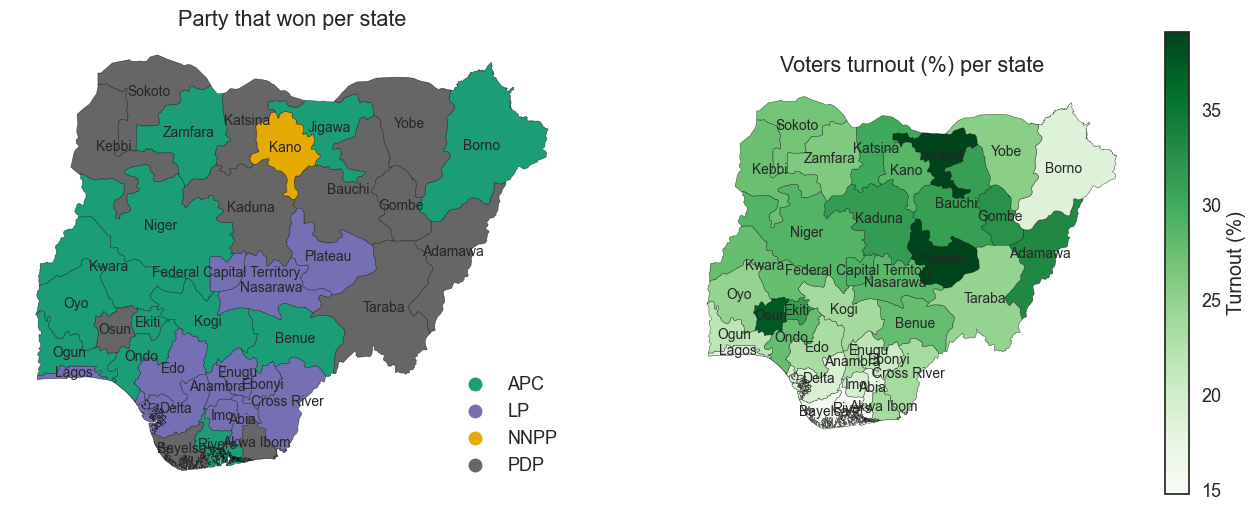

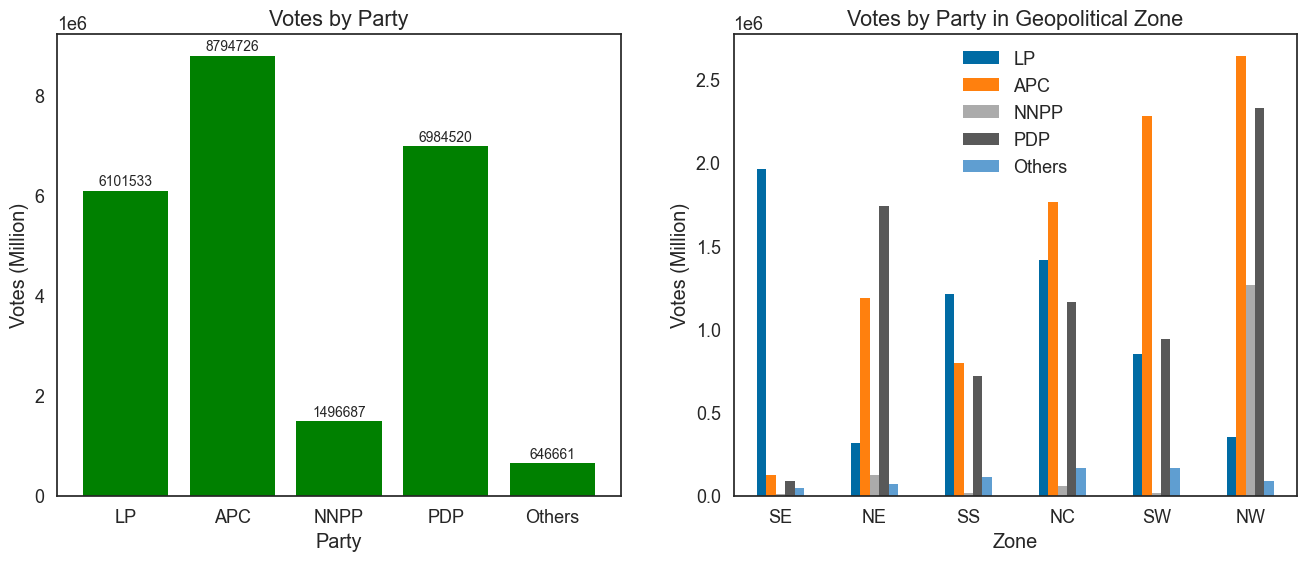

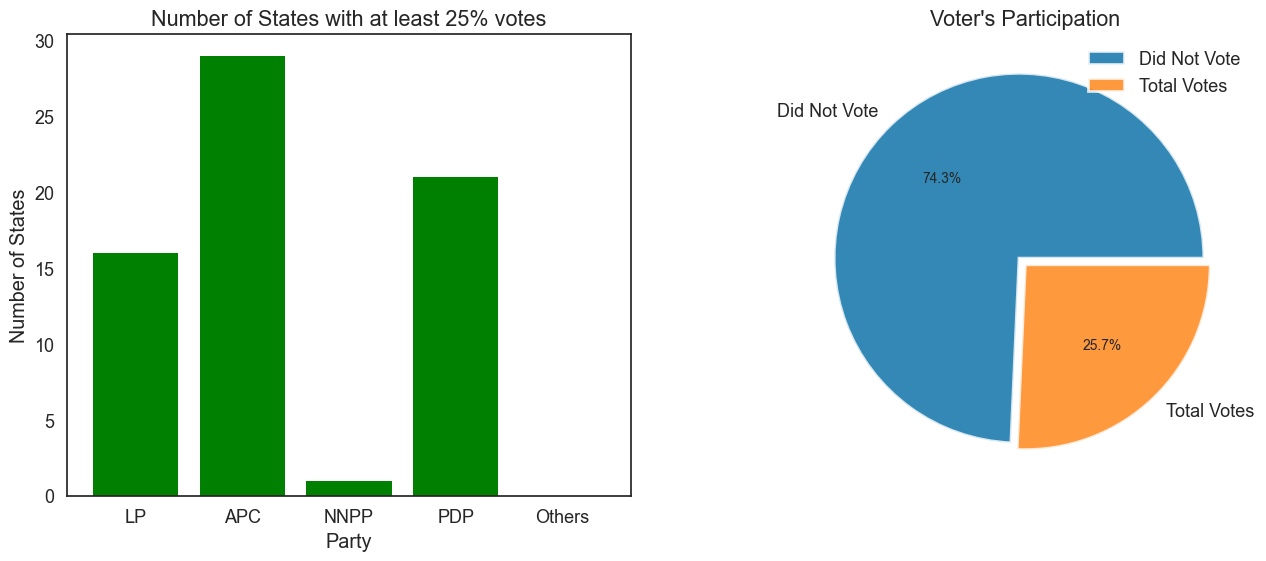

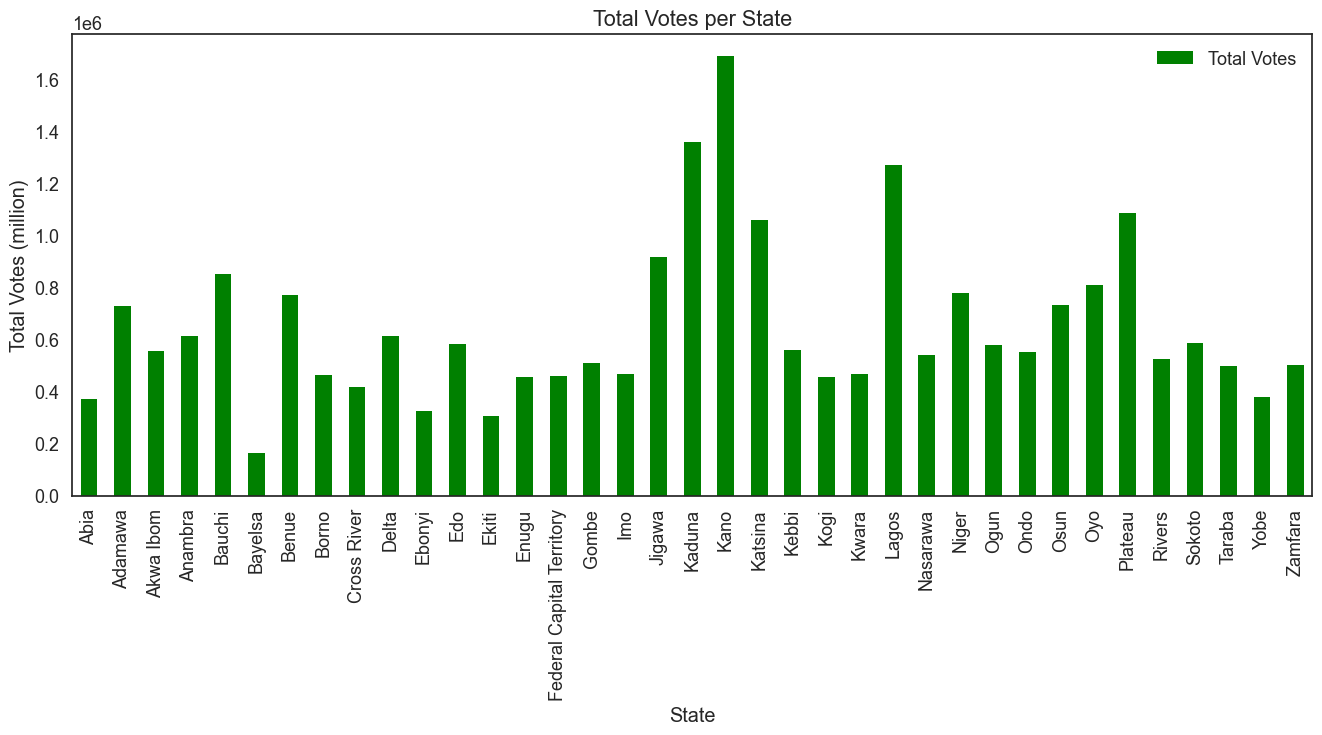

In [112]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

merged_df.plot(column='Winner Party', edgecolor=(0, 0, 0, 0.6), cmap='Dark2', legend=True, ax=ax1, legend_kwds={'loc': 'lower right'})
ax1.set_title('Party that won per state')
ax1.set_axis_off()

merged_df.plot(column='Voters Turnout(%)',cmap='Greens',legend=True,edgecolor=(0,0,0,.6),ax=ax2, legend_kwds={'label':'Turnout (%)'})
ax2.set_title('Voters turnout (%) per state')
ax2.set_axis_off()


for idx, row in merged_df.iterrows():
    state_name = row['NAME_1']
    centroid = row['geometry'].centroid
    ax1.annotate(text=state_name, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=10)
    ax2.annotate(text=state_name, xy=(centroid.x, centroid.y), ha='center', va='center', fontsize=10)

plt.savefig('figure1.png', dpi=110, bbox_inches='tight')
plt.show()

parties = major_parties + ['Others']

zone_vote = {}
for i in df['Zone'].unique():
    zone_vote[i] = dict(df.where(df.Zone == i).dropna().reset_index().drop('index', axis=1)[parties].sum())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# Create a bar chart of the votes by party
ax1.bar(parties, df[parties].sum(), color='green')
ax1.set_title('Votes by Party')
ax1.set_xlabel('Party')
ax1.set_ylabel('Votes (Million)')

# Add the vote counts to each bar
for i, v in enumerate(df[parties].sum()):
    ax1.text(i, v + 100000, str(v), ha='center')

# Create a bar chart of the votes by party in each zone
zone_df = pd.DataFrame(zone_vote).transpose()
ax2=zone_df.plot(kind='bar', ax=ax2, rot=0)
ax2.set_title('Votes by Party in Geopolitical Zone')
ax2.set_xlabel('Zone')
ax2.set_ylabel('Votes (Million)')

plt.savefig('figure2.png', dpi=110, bbox_inches='tight')
plt.show()

# calculate the number of states where each party received at least 25% of the votes
min_percent = {party: len(df.where(df[party] >= df['Total Votes'] / 4).dropna().reset_index().drop('index', axis=1)) for party in parties}

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# create a bar chart with the number of states where each party received at least 25% of the votes
ax1.bar(min_percent.keys(), min_percent.values(), color='green')
ax1.set_title('Number of States with at least 25% votes')
ax1.set_xlabel('Party')
ax1.set_ylabel('Number of States')

votes_df = df[['Did Not Vote', 'Total Votes']].sum().to_frame().T


# create a pie chart with the total number of registered voters and total votes
wedgeprops = {'linewidth': 2, 'edgecolor': 'white', 'alpha': 0.8}
ax2.pie(votes_df.values[0], labels=votes_df.columns, autopct='%1.1f%%', wedgeprops=wedgeprops, explode=(0.05, 0))
ax2.set_title('Voter\'s Participation')
ax2.legend(votes_df.columns)

plt.savefig('figure3.png', dpi=110, bbox_inches='tight')
# show the plot
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
df[['State', 'Total Votes']].plot(x='State', kind='bar', ax=ax, color='green')
ax.set_title('Total Votes per State')
ax.set_xlabel('State')
ax.set_ylabel('Total Votes (million)')
plt.savefig('figure4.png', dpi=110, bbox_inches='tight')
plt.show()


